In [16]:
import numpy as np
import os,random,shutil
np.random.seed(7)

In [17]:
#!/usr/bin/python3
# -*- coding: utf8 -*-

import numpy as np
import tensorflow as tf
import os, random, shutil
np.random.seed(7)

FOLDER = '../data/'
train_data_dir = '../data/train/'
val_data_dir = '../data/validation/'
train_samples_num = 2250 # train set中全部照片数
val_samples_num = 250
IMG_W, IMG_H, IMG_CH = 224, 224, 3 # 单张图片的大小
batch_size = 50
epochs = 50 # 用比较少的epochs数目做演示，节约训练时间
class_num = 5 # 此处有5个类别
save_folder = '../data/bottleneck/'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [18]:
# 此处的训练集和测试集并不是原始图片的train set和test set，而是用VGG16对图片提取的特征，这些特征组成新的train set和test set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255) # 不需图片增强

    # build the VGG16 network
    model = applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3)) 
    # 使用imagenet的weights作为VGG16的初始weights,由于只是特征提取，故而只取前面的卷积层而不需要DenseLayer，故而include_top=False

    generator = datagen.flow_from_directory( # 产生train set
        train_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode='categorical', # 这个地方要修改，要不然出错
        shuffle=False) # 必须为False，否则顺序打乱之后，和后面的label对应不上。
    bottleneck_features_train = model.predict_generator(
        generator, train_samples_num // batch_size) 
    np.save(os.path.join(save_folder,'bottleneck_features_train.npy'), bottleneck_features_train)
    print('bottleneck features of train set is saved.')

    generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, val_samples_num // batch_size)
    np.save(os.path.join(save_folder,'bottleneck_features_val.npy'),bottleneck_features_validation)
    print('bottleneck features of test set is saved.')

In [19]:
save_bottleneck_features()

Found 2250 images belonging to 5 classes.
bottleneck features of train set is saved.
Found 250 images belonging to 5 classes.
bottleneck features of test set is saved.


In [20]:
def my_model():
    '''
    自定义一个模型，该模型仅仅相当于一个分类器，只包含有全连接层，对提取的特征进行分类即可
    :return:
    '''
    # 模型的结构
    model = Sequential()
    model.add(tf.keras.layers.GlobalAveragePooling2D())
#     model.add(Flatten(input_shape=train_data.shape[1:])) # 将所有data进行flatten
#     model.add(Dense(256, activation='relu')) # 256个全连接单元
#     model.add(Dropout(0.5)) # dropout正则

    model.add(Dense(class_num, activation='softmax')) # 与二分类不同之处：要用Dense(class_num)和softmax

    # 模型的配置
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) # model的optimizer等

    return model

In [21]:
from keras.utils import to_categorical
# 只需要训练分类器模型即可，不需要训练特征提取器
train_data = np.load(os.path.join(save_folder,'bottleneck_features_train.npy')) # 加载训练图片集的所有图片的VGG16-notop特征
train_labels = np.array([0] * 450 + [1] * 450 + [2] * 450 + [3] * 450 + [4] * 450)
# label是每个类别80张图片，共5个类别
# 设置标签，并规范成Keras默认格式
train_labels = to_categorical(train_labels, class_num)

validation_data = np.load(os.path.join(save_folder,'bottleneck_features_val.npy'))
validation_labels = np.array([0] * 50 + [1] * 50 + [2] * 50 + [3] * 50 + [4] * 50)
validation_labels = to_categorical(validation_labels, class_num)

# 构建分类器模型
clf_model=my_model()
history_ft = clf_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))

Epoch 1/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4361 - accuracy: 0.8680 - val_loss: 0.1349 - val_accuracy: 0.9760
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1307 - accuracy: 0.9667 - val_loss: 0.0740 - val_accuracy: 0.9760
Epoch 3/50
45/45 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.9796 - val_loss: 0.0531 - val_accuracy: 0.9840
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 0.0635 - val_accuracy: 0.9760
Epoch 5/50
45/45 [==============================] - 0s 5ms/step - loss: 0.0378 - accuracy: 0.9911 - val_loss: 0.0445 - val_accuracy: 0.9800
Epoch 6/50
45/45 [==============================] - 0s 5ms/step - loss: 0.0269 - accuracy: 0.9947 - val_loss: 0.0408 - val_accuracy: 0.9880
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.0203 - accuracy: 0.9973 - val_loss: 0.0485 - val_accuracy: 0.9760
Epoch 8/50
45/45 [==

In [66]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training(history):
    plt.figure(12)
    
    plt.subplot(121)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b',label='train_acc')
    plt.plot(epochs, val_acc, 'r',label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    
    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b',label='train_loss')
    plt.plot(epochs, val_loss, 'r',label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()
 
    plt.show()

KeyError: 'acc'

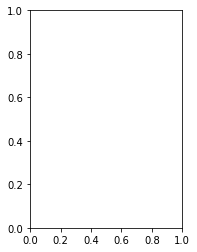

In [67]:
plot_training(history_ft)

In [22]:
clf_model.save_weights(os.path.join(save_folder,'top_FC_model'))
clf_model.save("../models/MobileNet/mobilenet.h5")